In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

silent_volts_path_1 = '/data 8 class/link 8 classes 1 - Device_0_Volts.csv'
silent_volts_path_2 = '/data 8 class/link 8 classes 2 - Device_0_Volts (1).csv'
silent_labels_path = '/data 8 class/Yaro Silent 5 Labels.csv'

In [ ]:
silent_volts_1 = pd.read_csv(silent_volts_path_1).iloc[:, :6].to_numpy()
silent_volts_2 = pd.read_csv(silent_volts_path_2).iloc[:, :6].to_numpy()

In [ ]:
silent_labels = pd.read_csv(silent_labels_path, header=None).to_numpy()

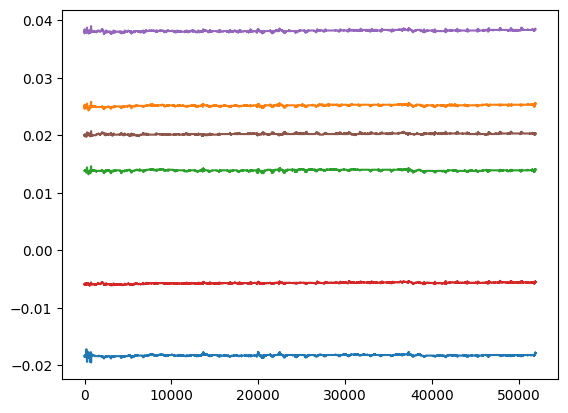

In [ ]:
plt.plot(silent_volts_1);

In [ ]:
import numpy as np
import scipy.signal as signal

def preprocess_signals_gpt(signals):
    # Normalizing by initial values
    initial_values = signals[0, :][np.newaxis, :]
    signals /= initial_values

    # Centering signals around zero mean
    signals -= signals.mean(axis=0, keepdims=True)

    # High-pass filter to remove low frequency drifts
    highpass_cutoff = 0.5  # Frequency in Hz
    fs = 250  # Sampling rate of 250 Hz
    b, a = signal.butter(1, highpass_cutoff / (fs / 2), btype='high')  # Normalized frequency
    signals = signal.filtfilt(b, a, signals, axis=0)


    # Notch filter at 60 Hz and its harmonics
    for harmonic in [60, 120]:  # Assuming 120 Hz is below Nyquist frequency for your sampling rate
        b, a = signal.iirnotch(harmonic / (fs / 2), Q=30)  # Normalized frequency, Q is the quality factor
        signals = signal.filtfilt(b, a, signals, axis=0)

    # Ricker wavelet convolution for heartbeat artifact removal
    widths = np.arange(1, 10)
    # Applying CWT individually for each signal
    for i in range(signals.shape[1]):  # Loop over channels
        signal_1d = signals[:, i]
        cwtmatr = signal.cwt(signal_1d, signal.ricker, widths)
        # Subtracting the mean of the wavelet-transformed signal from the original signal
        signals[:, i] -= cwtmatr.mean(axis=0)

    # Band-pass filter to allow frequencies from 0.5 to 8 Hz
    bandpass_lowcut = 0.5
    bandpass_highcut = 8
    b, a = signal.butter(1, [bandpass_lowcut / (fs / 2), bandpass_highcut / (fs / 2)], btype='band')
    signals = signal.filtfilt(b, a, signals, axis=0)

    return signals

# Use with your signals data, assuming silent_volts_df.to_numpy() is your signals
preprocessed_signals_1 = silent_volts_1.copy()
preprocessed_signals_2 = silent_volts_2.copy()
preprocessed_signals_1 = preprocess_signals_gpt(preprocessed_signals_1)
preprocessed_signals_2 = preprocess_signals_gpt(preprocessed_signals_2)

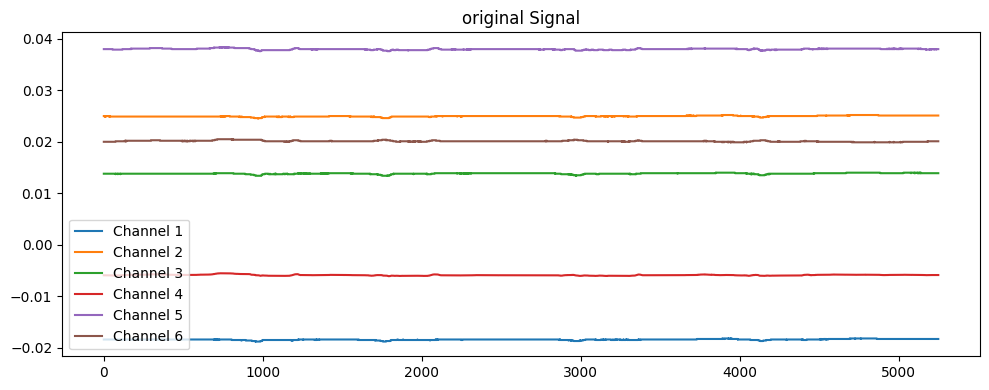

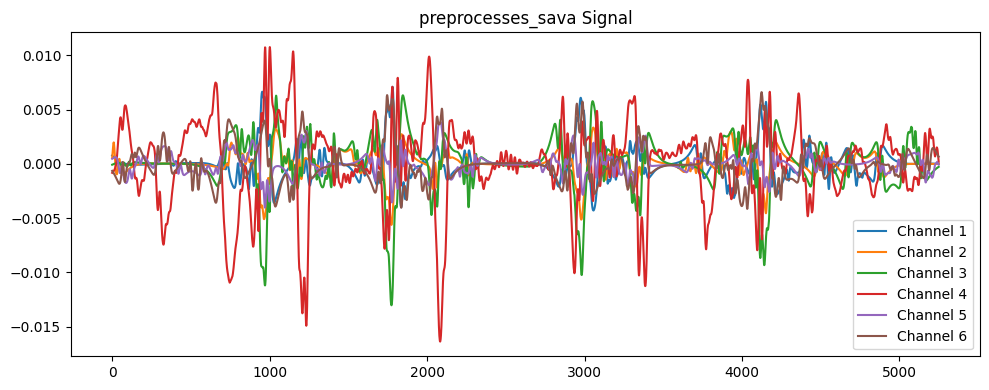

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signals, start_sample=2500, end_sample=2500+250*3, signal_label=''):
    """
    Plots all channels of the original signal in one plot for a specified sample range.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    num_channels = signals.shape[1]
    for channel in range(num_channels):
        ax.plot(signals[start_sample:end_sample, channel], label=f'Channel {channel+1}')
    ax.set_title(f'{signal_label} Signal')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Note: Before using plot_signal_chunks_combined, ensure your chunks are correctly formatted
# as a list of 2D numpy arrays, where each array represents a chunk with shape (chunk_size, num_channels).

plot_signal(silent_volts_1, 1250, 2500+250*16, 'original')
plot_signal(preprocessed_signals_1, 1250, 2500+250*16, 'preprocesses_sava') # this one is the best so fat but should be also improved

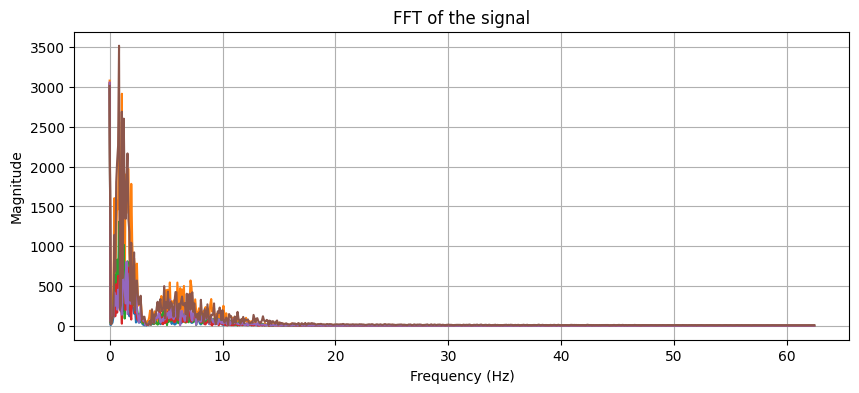

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # Sample rate and duration
fs = 250  # Sampling frequency in Hz

# Plotting the FFT
plt.figure(figsize=(10, 4))
for i in range(6):
  #y = preprocessed_signals[2500:2500+250*12,i]
  #y = silent_volts_df.to_numpy()[2500:2500+250*12,i]
  y = preprocessed_signals_1[2500:2500+250*12,i]
  y = y/y[0]-1
  # Compute the FFT
  y_fft = np.fft.fft(y)
  frequencies = np.fft.fftfreq(y.size, 1/fs)

  # Since the FFT output is symmetric, we only need to plot the first half for real signals
  n = y.size // 4  # Half of the signal length
  plt.plot(frequencies[:n], np.abs(y_fft[:n]))  # Plot magnitude spectrum

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of the signal')
plt.grid(True)
plt.show()

# now matching signal with labels and training the model

In [ ]:
import numpy as np
import pandas as pd


# Function to chunk the multichannel voltage signals into 5-second chunks with a 2.5 second offset
def chunk_signals_from_offset_multichannel(preprocessed_signals, chunk_size=250*5, offset=250*5):
    chunks = []
    # Calculate the number of rows to skip at the start based on the offset
    start_index = offset
    # Calculate the number of chunks possible with the given offset and chunk size
    for i in range(start_index, len(preprocessed_signals), chunk_size):
        # Ensure the chunk does not exceed the dataframe's length
        if i + chunk_size <= len(preprocessed_signals):
            chunk = preprocessed_signals[i:i + chunk_size]  # This keeps the chunk in a multichannel format
            chunks.append(chunk)
    return chunks

# Use the adjusted chunking function for multichannel data
silent_volts_chunks_1 = chunk_signals_from_offset_multichannel(preprocessed_signals_1)
silent_volts_chunks_2 = chunk_signals_from_offset_multichannel(preprocessed_signals_2)

# Print lengths to verify chunking
print(f"Total number of chunks before aligning: silent_volts_chunks_1 {len(silent_volts_chunks_1)}")
print(f"Total number of chunks before aligning: silent_volts_chunks_2 {len(silent_volts_chunks_2)}")

# Since each chunk now is a 2D array (1250x6), we need to adjust how we align and handle these with labels.
# Align the chunks with the binary labels
min_length_1 = min(len(silent_volts_chunks_1), silent_labels.shape[0])
silent_volts_chunks_aligned_1 = silent_volts_chunks_1[:min_length_1]
silent_labels_aligned_1 = silent_labels[:min_length_1]

min_length_2 = min(len(silent_volts_chunks_2), silent_labels.shape[0])
silent_volts_chunks_aligned_2 = silent_volts_chunks_2[:min_length_2]
silent_labels_aligned_2 = silent_labels[:min_length_2]

silent_volts_chunks_aligned = silent_volts_chunks_aligned_1 + silent_volts_chunks_aligned_2
silent_labels_aligned = np.concatenate([silent_labels_aligned_1, silent_labels_aligned_2], axis = 0)

# Assuming voiced_labels_df is loaded and contains binary labels ('yes'/'no' converted to 1/0)
commands = pd.DataFrame(silent_labels_aligned).loc[:,0].unique()
n_commands = len(commands)
#convert to one-hot encoding
print(f"Commands:", commands)

# Mapping of commands to their indices
command_to_index = {cmd: i for i, cmd in enumerate(commands)}

# Adjusted code to handle silent_labels containing numpy arrays of strings
encoded_sample = np.zeros((len(silent_labels_aligned), len(commands)))

for i, cmd_array in enumerate(silent_labels_aligned):
    # Assuming cmd_array is a numpy array with a single string element
    cmd = cmd_array.item()  # This extracts the string from the numpy array
    if cmd in command_to_index:  # Check if the command exists in the dictionary
        index = command_to_index[cmd]
        encoded_sample[i, index] = 1
    else:
        print(f"Command not found: {cmd}")

Total number of chunks before aligning: silent_volts_chunks_1 40
Total number of chunks before aligning: silent_volts_chunks_2 40
Commands: ['Apply to SPC for me' 'Book me a Waymo' 'Presidio' 'Launch MultiOn'
 'Walk forward' 'Walk backward' 'Turn left' 'Turn right']


In [ ]:
# Print lengths to verify alignment
print(f'Number of aligned chunks: {len(silent_volts_chunks_aligned)}')
print(f'Number of aligned labels: {len(silent_labels_aligned)}')

# Verify that the lengths match
if len(silent_volts_chunks_aligned) == len(silent_labels_aligned):
    print("The number of chunks and labels are correctly aligned.")
else:
    print("Mismatch in the number of chunks and labels.")

# Inspect first aligned chunk
if silent_volts_chunks_aligned:  # Check if there's at least one chunk
    example_chunk = np.array(silent_volts_chunks_aligned[0])
    # Append the binary label to the last column of the chunk
    label_for_chunk = silent_labels_aligned[0]
    print(f"Example chunk shape (before label): {example_chunk.shape}")
    print(f"Label for example chunk: {label_for_chunk}")
else:
    print("No chunks available for demonstration.")

Number of aligned chunks: 80
Number of aligned labels: 80
The number of chunks and labels are correctly aligned.
Example chunk shape (before label): (1250, 6)
Label for example chunk: ['Apply to SPC for me']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Flatten each chunk for use in a fully connected neural network
#X = np.array([chunk.flatten() for chunk in silent_volts_chunks_aligned]) for simple binary ok
#X = np.array([chunk.mean(axis = 1) for chunk in silent_volts_chunks_aligned]) for simple binary ok
X = np.array(silent_volts_chunks_aligned) # for CNN
X = X.transpose(0, 2, 1)



y = encoded_sample

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to torch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # add an extra dimension to y
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)  # add an extra dimension to y

# Create tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [ ]:
X_train.shape

(64, 6, 1250)

In [ ]:
y_train.shape

(64, 8)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Assuming the input dimension is (batch_size, channels, height, width)
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=400, kernel_size=12)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=6)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=3)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=3)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv1d(in_channels=400, out_channels=400, kernel_size=3)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate the size of the flattened features after the last pooling layer
        self._to_linear = None
        self.convs = nn.Sequential(self.conv1, nn.ReLU(), self.pool1,
                                   self.conv2, nn.ReLU(), self.pool2,
                                   self.conv3, nn.ReLU(), self.pool3,
                                   self.conv4, nn.ReLU(), self.pool4,
                                   self.conv5, nn.ReLU(), self.pool5)
        self._get_conv_output((6, 1250))  # Example size

        self.fc1 = nn.Linear(self._to_linear, 250)  # The size will depend on the final pooling layer output
        self.drop1 = nn.Dropout(p=0.7)
        self.fc2 = nn.Linear(250, 8)
        self.drop2 = nn.Dropout(p=0.5)

    def _get_conv_output(self, shape):
        # Determine the size of the features after the conv and pooling layers
        with torch.no_grad():
            input = torch.rand(1, *shape)
            output = self.convs(input)
            self._to_linear = output.data.view(1, -1).size(1)

    def forward(self, x):
        # Pass the input through the conv layers
        x = self.convs(x)

        # Flatten the output for the dense layers
        x = x.view(-1, self._to_linear)

        # Pass the output through the dense layers
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)

        # Softmax activation for the output
        #x = torch.sigmoid(x) was here for binary problem
        x = F.softmax(x, dim=1)
        return x


class SimpleFNN(nn.Module): # works fine for binary classification problem (96% accuracy on a balances test set)
    def __init__(self, input_size):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class SimpleFNN_8(nn.Module): # does not work on 80 points dataset (8 classses, 10 times each) top F1 score was 0.2
    def __init__(self, input_size):
        super(SimpleFNN_8, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 8)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Model initialization
input_size = X_train.shape[1]
#model = SimpleFNN_8(input_size).to(device)
model = CustomCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # for multi-class classification. use BLELoss for binary
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust lr as needed

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).squeeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation part
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(list(torch.argmax(labels.cpu(), dim=2).squeeze().numpy()))

    # Calculate metrics
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='macro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    # For multiclass ROC AUC, ensure your labels are properly formatted

    # This might need adjustment based on the label and prediction format
    # Convert labels to one-hot encoded format
    true_labels = F.one_hot(torch.tensor(all_labels), num_classes=8).numpy()
    # Convert predictions to softmax probabilities
    #pred_probs = F.softmax(torch.tensor(all_preds), dim=1).numpy()
    # Calculate ROC AUC score
    roc_auc = 1# roc_auc_score(true_labels, pred_probs, multi_class='ovr')

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%, F1: {f1:.4f}, Weighted F1: {weighted_f1:.4f}, ROC AUC: {roc_auc:.4f}')


cuda
Epoch 1/200, Loss: 2.0862, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 2/200, Loss: 2.0790, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 3/200, Loss: 2.0865, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 4/200, Loss: 2.0789, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 5/200, Loss: 2.0821, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 6/200, Loss: 2.0819, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 7/200, Loss: 2.0792, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 8/200, Loss: 2.0814, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 9/200, Loss: 2.0788, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 10/200, Loss: 2.0792, Accuracy: 6.25%, F1: 0.0147, Weighted F1: 0.0074, ROC AUC: 1.0000
Epoch 11/200, Loss: 2.0819, Accuracy: 6.25%, F1: 0.0147, Weighte

In [ ]:
outputs

tensor([[0.1309, 0.1309, 0.1309, 0.1621, 0.1309, 0.0934, 0.1067, 0.1145],
        [0.1353, 0.1149, 0.1048, 0.1353, 0.1353, 0.1037, 0.1353, 0.1353],
        [0.1399, 0.1147, 0.0953, 0.1399, 0.1271, 0.1399, 0.1031, 0.1399],
        [0.1219, 0.0992, 0.1219, 0.1697, 0.1219, 0.1219, 0.1219, 0.1214]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
import torch
from safetensors.torch import save_file

# Assuming 'model' is your trained model
model_path = "SimpleFNN_8_mar_8_1700.st"  # Use .st extension for SafeTensors

# Save model's state_dict with SafeTensors
state_dict = model.state_dict()
save_file(state_dict, model_path)

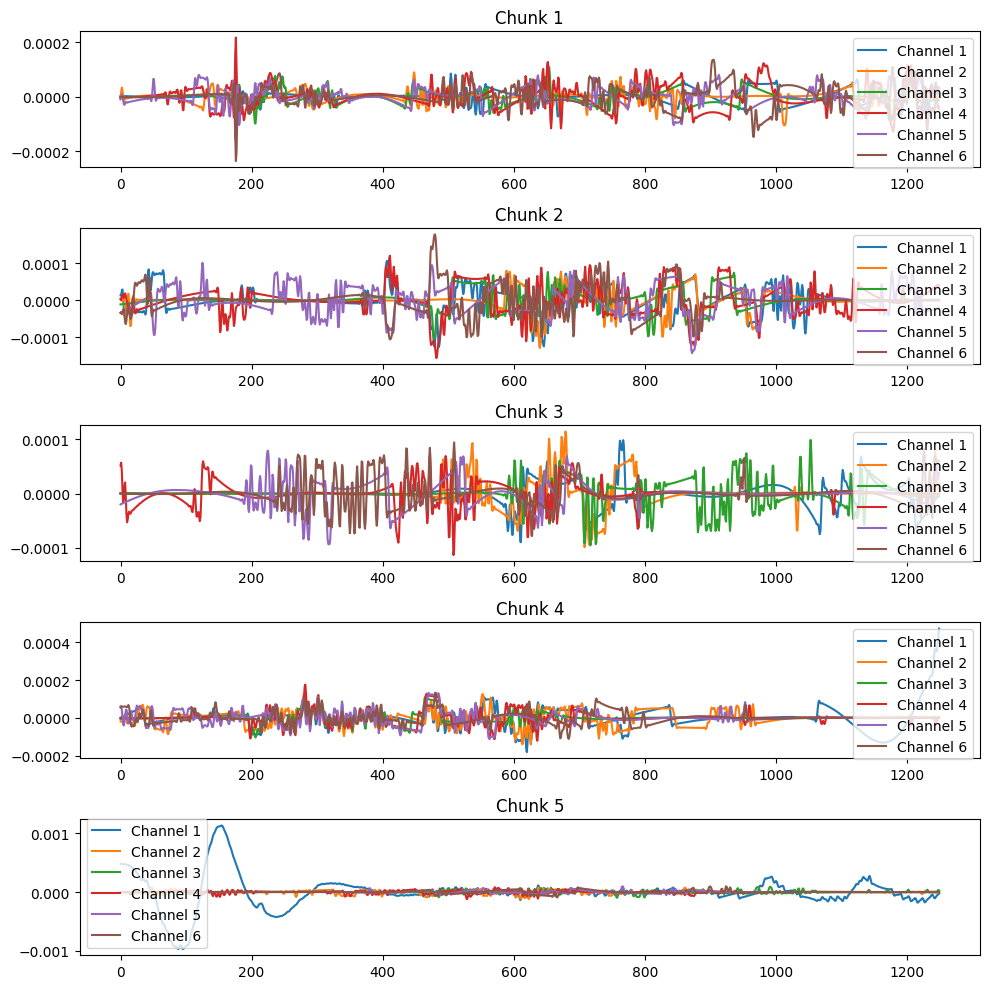

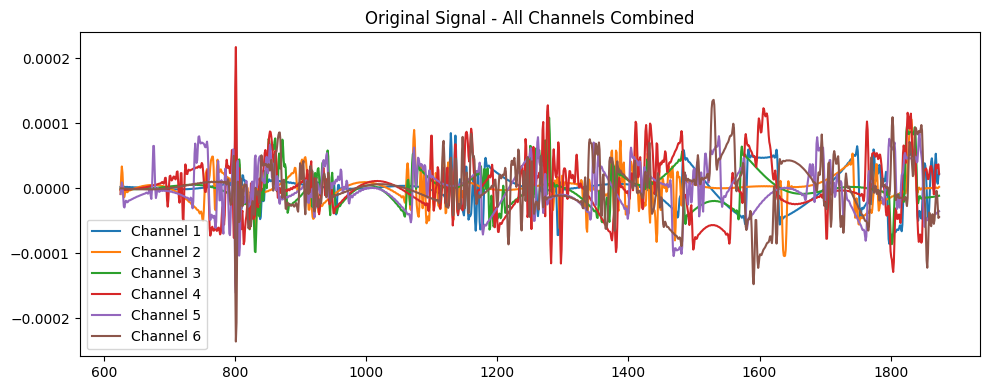

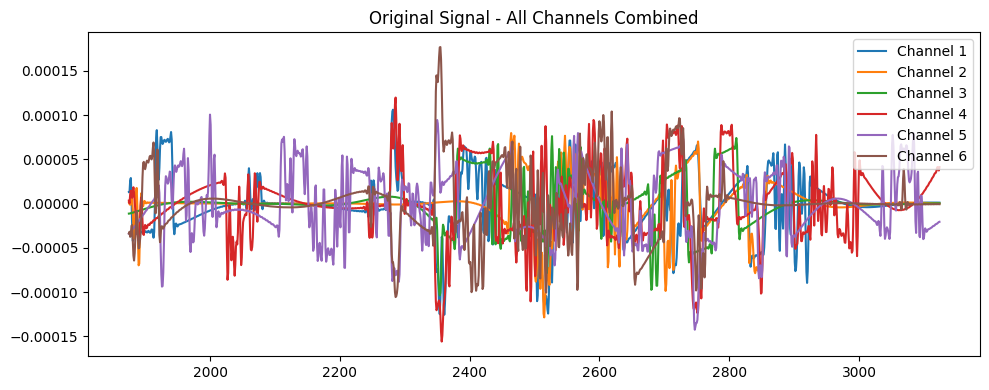

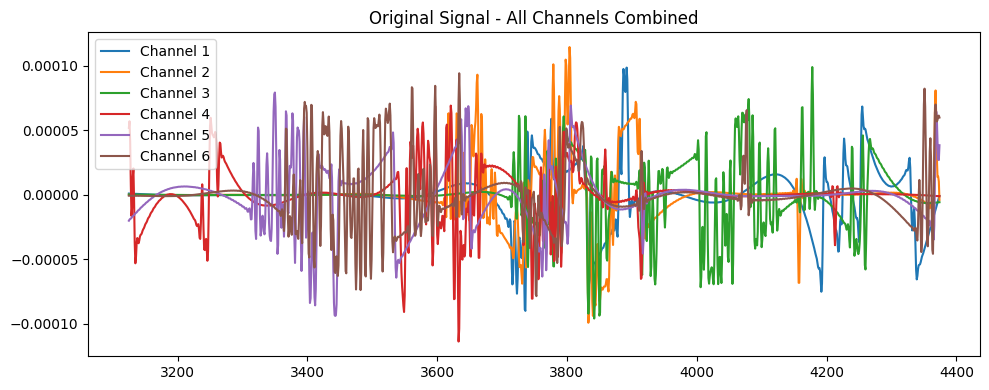

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal_chunks_combined(chunks, num_chunks=5):
    """
    Plots combined channels for each signal chunk.
    """
    fig, axs = plt.subplots(num_chunks, 1, figsize=(10, 2 * num_chunks), squeeze=False)
    for i, chunk in enumerate(chunks[:num_chunks]):
        for channel in range(chunk.shape[1]):
            axs[i, 0].plot(chunk[:, channel], label=f'Channel {channel+1}')
        axs[i, 0].set_title(f'Chunk {i+1}')
        axs[i, 0].legend()
    plt.tight_layout()
    plt.show()

def plot_original_signal_combined(df, start_sample=625, end_sample=1875):
    """
    Plots all channels of the original signal in one plot for a specified sample range.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    num_channels = df.shape[1]
    for channel in range(num_channels):
        ax.plot(df.iloc[start_sample:end_sample, channel], label=f'Channel {channel+1}')
    ax.set_title('Original Signal - All Channels Combined')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Note: Before using plot_signal_chunks_combined, ensure your chunks are correctly formatted
# as a list of 2D numpy arrays, where each array represents a chunk with shape (chunk_size, num_channels).

plot_signal_chunks_combined(voiced_volts_chunks, num_chunks=5)
plot_original_signal_combined(voiced_volts_df, 625, 1875)
plot_original_signal_combined(voiced_volts_df, 1875, 3125)
plot_original_signal_combined(voiced_volts_df, 3125, 4375)

## plot all yesses an nos averaged

In [ ]:
import numpy as np

def smooth_array(array, window_size=5):
    """
    Smooths each row of a 2D array using a moving average filter.

    Parameters:
    - array: 2D numpy array of shape (6, 1250)
    - window_size: The size of the moving window for the moving average filter

    Returns:
    - smoothed_array: 2D numpy array of shape (6, 1250) after smoothing
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if window_size > array.shape[0]:
        raise ValueError("Window size larger than array dimension.")

    # Define the filter: simple moving average
    filter_kernel = np.ones(window_size) / window_size

    # Apply the filter along the second axis for each row
    smoothed_array = np.apply_along_axis(lambda m: np.convolve(m, filter_kernel, mode='same'), axis=0, arr=array)

    return smoothed_array

In [ ]:
yeses = []
nos = []
for label, chunk  in zip(voiced_binary_labels_aligned, voiced_volts_chunks_aligned):
  if label == 1:
    yeses.append(smooth_array(chunk, 10))
  else:
    nos.append(smooth_array(chunk, 10))
nos = np.array(nos)
yeses = np.array(yeses)

NameError: name 'nos' is not defined

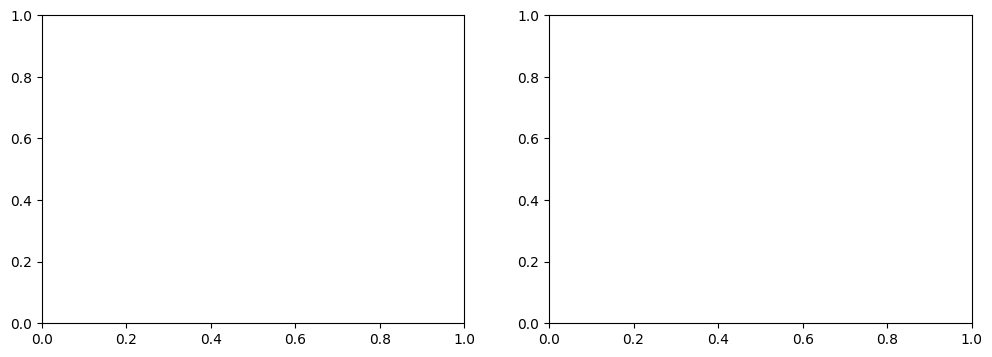

In [ ]:
# Plotting YES vs NO smoothened
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(nos[6:].mean(axis = 0));
axs[1].plot(yeses[6:].mean(axis = 0));
axs[0].set_title("'No' Avg, n=52")
axs[1].set_title("'Yes' Avg, n=47")
#for ax in axs:
#    ax.legend()
plt.show()

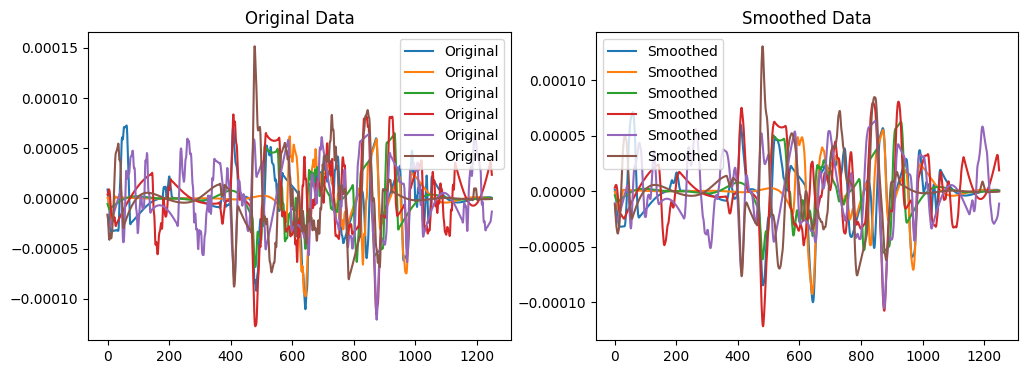

In [ ]:
# Smooth the array
smoothed_nos = smooth_array(nos[0], 10)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(nos[0], label='Original')
axs[1].plot(smoothed_nos, label='Smoothed')
axs[0].set_title('Original Data')
axs[1].set_title('Smoothed Data')
for ax in axs:
    ax.legend()
plt.show()

NameError: name 'nos' is not defined

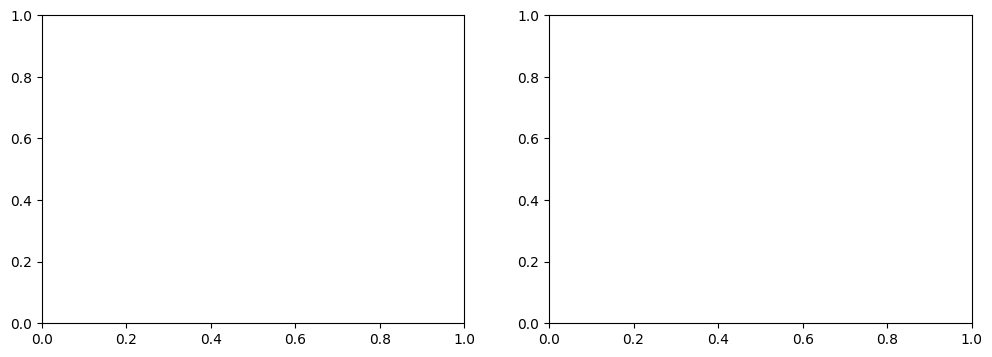

In [ ]:
# Plotting YES vs NO smoothened
for sample_n in range(1):
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(nos[sample_n])
  axs[1].plot(yeses[sample_n])
  axs[0].set_title(f'No, sample_n={sample_n}')
  axs[1].set_title(f'Yes, sample_n={sample_n}')
  #for ax in axs:
  #    ax.legend()
  plt.show()